# Условие

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
- [X] Выведите кол-во обучаемых параметров сети;    
- [ ] Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.
- [X] Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
- [ ] Выведите confusion matrix для тестовой подвыборки;    

# Особенности

У меня все выполнялось на cpu, разрешили взять половину

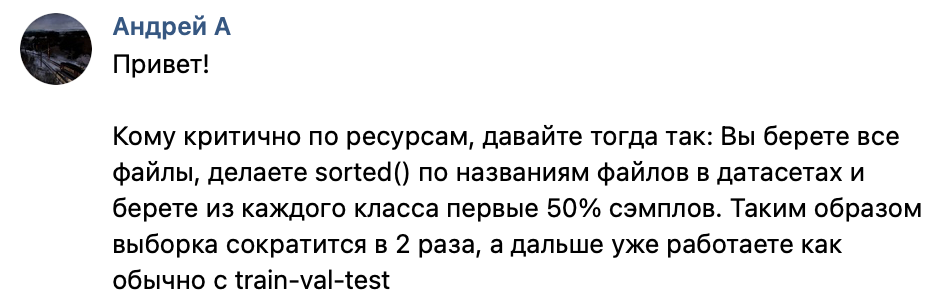


# Домашняя работа

## Подключаем билиотеки и константы

In [500]:
!pip install torchmetrics numpy torch matplotlib torchvision tqdm progressbar

In [498]:
import os
import warnings
import time
import progressbar

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import layers as l # Results from hw1 + hw2

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import no_grad, max, device, cuda
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import f1_score   

warnings.filterwarnings('ignore')
%matplotlib inline

In [499]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")
print(DEVICE)

cpu


## Подгрузка данных

In [496]:
SHAPE = 256
data_dir = './indoor_outdoor_dataset/'

# В идеале надо бы еще шум наложить, но я ограничен технически
transform = transforms.Compose([
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.95 * len(full_data))
test_size = int(0.05 * len(full_data))
del_size = len(full_data) - train_size - test_size
print(f'train_size = {train_size}\ntest_size = {test_size}\nnot_use = {del_size}')

train_data, test_data, _ = random_split(full_data, [train_size, test_size, del_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_size = 389997
test_size = 20526
not_use = 1


In [8]:
LEARNING_RATE = 0.01
EPOCH = 10

In [384]:
def plot(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train', linewidth=1.0)
    plt.plot(test_loss_epochs, label='Test', linewidth=1.0)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train', linewidth=1.0)
    plt.plot(test_accuracy_epochs, label='Test', linewidth=1.0)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [497]:
def plotLAF(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs, epochs=20):
    train = [ train_loss_epochs, train_accuracy_epochs, train_f1_epochs ]
    test = [ test_loss_epochs, test_accuracy_epochs, test_f1_epochs ]
    label = [ 'Loss', 'Accuracy', 'F1' ]
    plt.figure(figsize=(12.5, 4))
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.plot(train[(i - 1)], label='Train', linewidth=1.0)
        plt.plot(test[(i - 1)], label='Test', linewidth=1.0)
        plt.xlabel('Epochs')
        plt.ylabel(label[(i - 1)])
        plt.ylim([0, 1])
        plt.xlim([0, epochs])
        plt.legend(loc=0)
        plt.grid()
    plt.show()

## Модель на основе семинара 1 и 2

Решил написать модель на основе кода семинара 1 и 2. Но обучение было каким-то долгим и разрешили использовать модули из nn. Важное уточнение в начале для этого надо было конвертировать в серый цвет. Признал этот вариант тупиковым, так как:
1) Только в сером цвете происходит свертка, возможно информация из цветов теряется;
2) Надо было самому реализовать остальные возможности tourch
3) По моим ощущениям где-то внутри возникает bottle-neck

In [144]:
def train(network, epochs, learning_rate, loss=None):    
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
    
            prediction = network.forward(X)
            loss_batch = loss.forward(prediction, y)
            losses.append(loss_batch)

            dLdx = loss.backward()
            network.backward(dLdx)
            network.step(learning_rate)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        losses = []
        accuracies = []    
        for X, y in test_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            prediction = network.forward(X)
            loss_batch = loss.forward(prediction, y)
            losses.append(loss_batch)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
            
        print(
            '\rEpoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
                (epoch+1), epochs, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1], (time.time() - start_time))
        )
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Пример ниже прогонялся, пока эксперементировал. В начале были проблемы с обучением, был конфликт tourch+numpy. Решил позже, но уже решил не тратить время на переобучение модели, а перешел к следующему этапу

Epoch [1/20] (Train/Test) NLL: 0.648/0.000, Accuracy: 0.616/0.000 t: 8.5288 s
Epoch [2/20] (Train/Test) NLL: 0.620/0.000, Accuracy: 0.642/0.000 t: 8.5290 s
Epoch [3/20] (Train/Test) NLL: 0.600/0.000, Accuracy: 0.661/0.000 t: 8.6653 s
Epoch [4/20] (Train/Test) NLL: 0.577/0.000, Accuracy: 0.683/0.000 t: 8.6433 s
Epoch [5/20] (Train/Test) NLL: 0.552/0.000, Accuracy: 0.711/0.000 t: 8.6393 s
Epoch [6/20] (Train/Test) NLL: 0.521/0.000, Accuracy: 0.738/0.000 t: 8.7035 s
Epoch [7/20] (Train/Test) NLL: 0.497/0.000, Accuracy: 0.762/0.000 t: 8.8199 s
Epoch [8/20] (Train/Test) NLL: 0.453/0.000, Accuracy: 0.802/0.000 t: 8.6505 s
Epoch [9/20] (Train/Test) NLL: 0.418/0.000, Accuracy: 0.828/0.000 t: 8.5216 s
Epoch [10/20] (Train/Test) NLL: 0.390/0.000, Accuracy: 0.843/0.000 t: 8.7403 s
Epoch [11/20] (Train/Test) NLL: 0.361/0.000, Accuracy: 0.861/0.000 t: 8.5234 s
Epoch [12/20] (Train/Test) NLL: 0.329/0.000, Accuracy: 0.883/0.000 t: 8.5698 s
Epoch [13/20] (Train/Test) NLL: 0.280/0.000, Accuracy: 0.904/

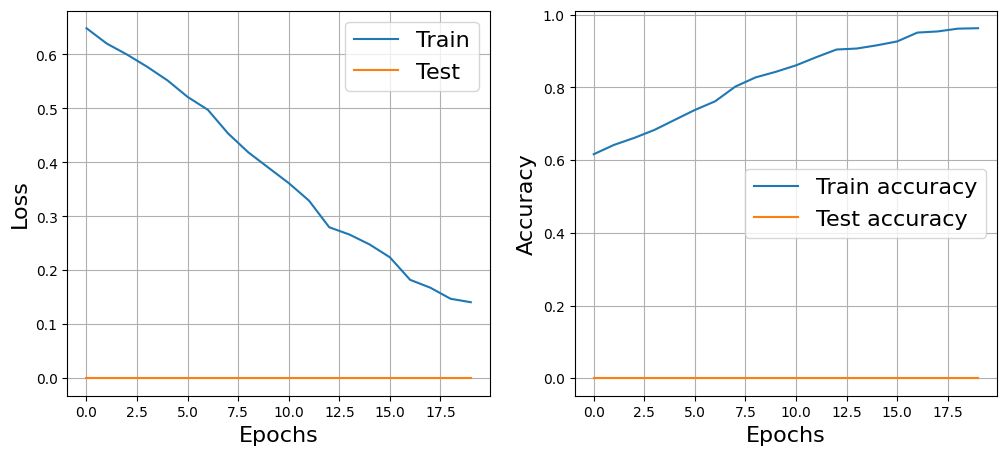

In [23]:
network = l.NeuralNetwork([
    l.Linear(SHAPE**2, 256), l.ReLU(),
    l.Linear(256, 2)
])
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, LEARNING_RATE, loss=l.NLLLoss())

## Модель с tourch

Для начала решил написать просто модель, чтобы прогнать тесты и посмотреть, что получается

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(SHAPE**2 , 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 2), nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, SHAPE**2)
        x = self.fc_layers(x)
        return x

In [ ]:
device = DEVICE
model = Net().to(device)
print(model) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in model.parameters()])))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

In [ ]:
def train_tourch(model, criterion, optimizerm, epochs):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = []
        running_acc = []
        test_loss = []
        test_acc = []
    
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(accuracy(outputs, labels))
        train_loss_epochs.append(np.mean(running_loss))
        train_accuracy_epochs.append(np.mean(running_acc))

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss.append(loss.item())
                test_acc.append(accuracy(outputs, labels))
        test_loss_epochs.append(np.mean(test_loss))
        test_accuracy_epochs.append(np.mean(test_acc))
            
        print(
            'Epoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
            (epoch+1), (epochs), train_loss_epochs[-1], test_loss_epochs[-1], train_accuracy_epochs[-1],
            test_accuracy_epochs[-1], (time.time() - start_time))
        )
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Epoch [1/20] (Train/Test) NLL: 0.642/0.627, Accuracy: 0.634/0.660 t: 219.2541 s
Epoch [2/20] (Train/Test) NLL: 0.611/0.610, Accuracy: 0.676/0.676 t: 201.2654 s
Epoch [3/20] (Train/Test) NLL: 0.594/0.603, Accuracy: 0.697/0.687 t: 207.3005 s
Epoch [4/20] (Train/Test) NLL: 0.583/0.597, Accuracy: 0.713/0.691 t: 201.8410 s
Epoch [5/20] (Train/Test) NLL: 0.573/0.594, Accuracy: 0.724/0.695 t: 201.9470 s
Epoch [6/20] (Train/Test) NLL: 0.564/0.593, Accuracy: 0.733/0.704 t: 202.4119 s
Epoch [7/20] (Train/Test) NLL: 0.556/0.586, Accuracy: 0.746/0.708 t: 202.8821 s
Epoch [8/20] (Train/Test) NLL: 0.548/0.592, Accuracy: 0.756/0.701 t: 202.3330 s
Epoch [9/20] (Train/Test) NLL: 0.539/0.585, Accuracy: 0.765/0.709 t: 200.2584 s
Epoch [10/20] (Train/Test) NLL: 0.532/0.595, Accuracy: 0.773/0.697 t: 200.1841 s
Epoch [11/20] (Train/Test) NLL: 0.525/0.591, Accuracy: 0.782/0.703 t: 193.7212 s
Epoch [12/20] (Train/Test) NLL: 0.518/0.590, Accuracy: 0.789/0.707 t: 194.1053 s
Epoch [13/20] (Train/Test) NLL: 0.511

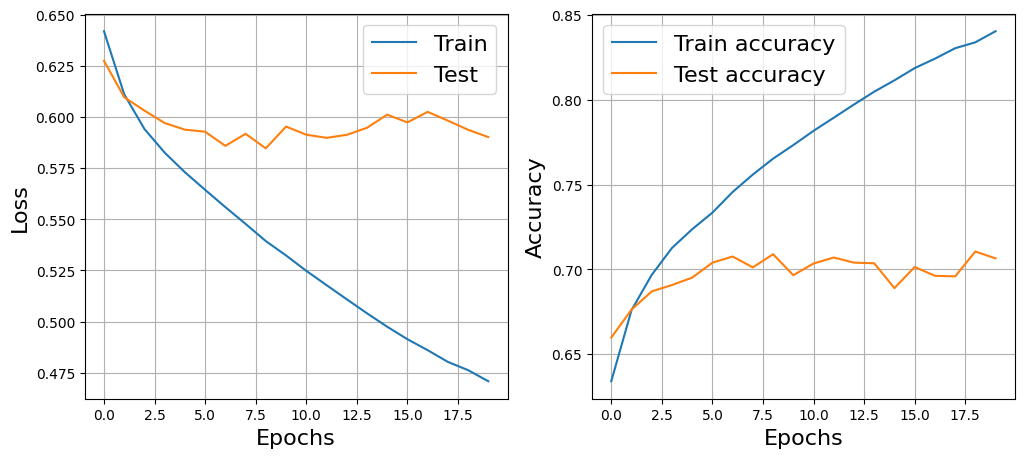

In [155]:
tr_r, ts_r, tr_ac_r, ts_ac_r = train_tourch(model, criterion, optimizer, 20)
plot(tr_r, ts_r, tr_ac_r, ts_ac_r)

### Калибровка

Переписал чтобы все было в класс

In [429]:
class Model:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self._f1_score = BinaryF1Score()

    def _accuracy(self, outputs, labels):
        self._pred = (outputs > 0.5).float()
        return torch.sum(self._pred == labels).item() / len(labels)

    def _f1(self, labels):
        return self._f1_score(self._pred, labels)
    
    def train(self, train_loader, test_loader, epochs):
        train_loss_epochs, train_accuracy_epochs, train_f1_epochs = [], [], []
        test_loss_epochs, test_accuracy_epochs, test_f1_epochs = [], [], []

        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            running_loss, running_acc, running_f1 = [], [], []
            test_loss, test_acc, test_f1 = [], [], []

            # Обучение
            self.model.train()
            for i, (inputs, labels) in enumerate(train_loader):
                labels = labels.float()

                self.optimizer.zero_grad()
                outputs = self.model(inputs).view(-1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss.append(loss.item())
                running_acc.append(self._accuracy(outputs, labels))
                running_f1.append(self._f1(labels))

            train_loss_epochs.append(np.mean(running_loss))
            train_accuracy_epochs.append(np.mean(running_acc))
            train_f1_epochs.append(np.mean(running_f1))

            # Прогон по тестовой выборке
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    labels = labels.float()

                    outputs = self.model(inputs).view(-1)
                    loss = self.criterion(outputs, labels)

                    test_loss.append(loss.item())
                    test_acc.append(self._accuracy(outputs, labels))
                    test_f1.append(self._f1(labels))

            test_loss_epochs.append(np.mean(test_loss))
            test_accuracy_epochs.append(np.mean(test_acc))
            test_f1_epochs.append(np.mean(test_f1))
        
            print(
                f'Epoch [{(epoch+1)}/{epochs}] (Train/Test) ',
                f'Loss: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}, ',
                f'Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}, ',
                f'F1: {train_f1_epochs[-1]:.3f}/{test_f1_epochs[-1]:.3f}, ',
                f't: {(time.time() - start_time):.3f} s'
            )
        plotLAF(
            train_loss_epochs, test_loss_epochs,
            train_accuracy_epochs, test_accuracy_epochs,
            train_f1_epochs, test_f1_epochs
        )
        return train_loss_epochs, test_loss_epochs, \
               train_accuracy_epochs, test_accuracy_epochs, \
               train_f1_epochs, test_f1_epochs

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs

In [481]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), # 256x256x32
            nn.MaxPool2d(kernel_size=2, stride=2),                 # 128x128x32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), # 128x128x64
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 64x64x64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), # 64x64x128
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 32x32x128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), # 32x32x256
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 16x16x256
            
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512), nn.ReLU(),
            nn.Linear(512, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [482]:
device = DEVICE
cnn = CNN().to(device)
print(cnn) 

criterion = nn.BCELoss()
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

print('Кол-во обучаемых параметров сети: ' + str(sum([p.numel() for p in cnn.parameters()])))

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=65536, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=1, bias=True)
    (16): Sigmoid()
  )
)
Кол-во обучаемых параметров сети: 33943873


  4%|█▋                                         | 1/25 [02:19<55:51, 139.65s/it]

Epoch [1/25] (Train/Test)  Loss: 0.690/0.686,  Accuracy: 0.534/0.528,  F1: 0.097/0.000,  t: 139.654 s


  8%|███▍                                       | 2/25 [04:43<54:23, 141.90s/it]

Epoch [2/25] (Train/Test)  Loss: 0.681/0.676,  Accuracy: 0.594/0.619,  F1: 0.319/0.416,  t: 143.464 s


 12%|█████▏                                     | 3/25 [07:22<54:54, 149.75s/it]

Epoch [3/25] (Train/Test)  Loss: 0.659/0.658,  Accuracy: 0.643/0.636,  F1: 0.547/0.514,  t: 159.106 s


 16%|██████▉                                    | 4/25 [10:02<53:53, 153.98s/it]

Epoch [4/25] (Train/Test)  Loss: 0.618/0.641,  Accuracy: 0.668/0.615,  F1: 0.623/0.679,  t: 160.455 s


 20%|████████▌                                  | 5/25 [12:41<51:55, 155.78s/it]

Epoch [5/25] (Train/Test)  Loss: 0.558/0.667,  Accuracy: 0.722/0.623,  F1: 0.694/0.364,  t: 158.985 s


 24%|██████████▎                                | 6/25 [15:20<49:41, 156.90s/it]

Epoch [6/25] (Train/Test)  Loss: 0.524/0.549,  Accuracy: 0.748/0.737,  F1: 0.716/0.737,  t: 159.061 s


 28%|████████████                               | 7/25 [18:03<47:38, 158.82s/it]

Epoch [7/25] (Train/Test)  Loss: 0.508/0.565,  Accuracy: 0.762/0.698,  F1: 0.740/0.723,  t: 162.768 s


 32%|█████████████▊                             | 8/25 [20:43<45:06, 159.20s/it]

Epoch [8/25] (Train/Test)  Loss: 0.492/0.554,  Accuracy: 0.772/0.710,  F1: 0.748/0.729,  t: 160.014 s


 36%|███████████████▍                           | 9/25 [23:24<42:34, 159.67s/it]

Epoch [9/25] (Train/Test)  Loss: 0.473/0.587,  Accuracy: 0.783/0.707,  F1: 0.753/0.738,  t: 160.712 s


 40%|████████████████▊                         | 10/25 [26:04<39:55, 159.72s/it]

Epoch [10/25] (Train/Test)  Loss: 0.460/0.500,  Accuracy: 0.794/0.754,  F1: 0.766/0.683,  t: 159.832 s


 44%|██████████████████▍                       | 11/25 [28:43<37:15, 159.70s/it]

Epoch [11/25] (Train/Test)  Loss: 0.455/0.552,  Accuracy: 0.797/0.721,  F1: 0.769/0.748,  t: 159.646 s


 48%|████████████████████▏                     | 12/25 [31:19<34:20, 158.46s/it]

Epoch [12/25] (Train/Test)  Loss: 0.443/0.476,  Accuracy: 0.798/0.797,  F1: 0.775/0.793,  t: 155.640 s


 52%|█████████████████████▊                    | 13/25 [33:54<31:31, 157.60s/it]

Epoch [13/25] (Train/Test)  Loss: 0.437/0.463,  Accuracy: 0.806/0.804,  F1: 0.784/0.772,  t: 155.623 s


 56%|███████████████████████▌                  | 14/25 [36:29<28:43, 156.65s/it]

Epoch [14/25] (Train/Test)  Loss: 0.425/0.459,  Accuracy: 0.805/0.789,  F1: 0.783/0.739,  t: 154.435 s


 60%|█████████████████████████▏                | 15/25 [39:03<25:59, 155.96s/it]

Epoch [15/25] (Train/Test)  Loss: 0.426/0.525,  Accuracy: 0.815/0.738,  F1: 0.792/0.635,  t: 154.383 s


 64%|██████████████████████████▉               | 16/25 [41:37<23:17, 155.31s/it]

Epoch [16/25] (Train/Test)  Loss: 0.420/0.474,  Accuracy: 0.808/0.819,  F1: 0.786/0.816,  t: 153.791 s


 68%|████████████████████████████▌             | 17/25 [44:11<20:39, 154.94s/it]

Epoch [17/25] (Train/Test)  Loss: 0.405/0.455,  Accuracy: 0.825/0.772,  F1: 0.808/0.703,  t: 154.082 s


 72%|██████████████████████████████▏           | 18/25 [46:45<18:02, 154.68s/it]

Epoch [18/25] (Train/Test)  Loss: 0.405/0.489,  Accuracy: 0.816/0.765,  F1: 0.793/0.678,  t: 154.063 s


 76%|███████████████████████████████▉          | 19/25 [49:20<15:27, 154.60s/it]

Epoch [19/25] (Train/Test)  Loss: 0.397/0.427,  Accuracy: 0.826/0.813,  F1: 0.806/0.789,  t: 154.409 s


 80%|█████████████████████████████████▌        | 20/25 [52:05<13:08, 157.72s/it]

Epoch [20/25] (Train/Test)  Loss: 0.391/0.420,  Accuracy: 0.829/0.818,  F1: 0.810/0.799,  t: 164.986 s


 84%|███████████████████████████████████▎      | 21/25 [54:46<10:35, 158.93s/it]

Epoch [21/25] (Train/Test)  Loss: 0.381/0.430,  Accuracy: 0.838/0.813,  F1: 0.819/0.790,  t: 161.762 s


 88%|████████████████████████████████████▉     | 22/25 [57:24<07:55, 158.64s/it]

Epoch [22/25] (Train/Test)  Loss: 0.377/0.434,  Accuracy: 0.837/0.797,  F1: 0.818/0.752,  t: 157.957 s


 92%|████████████████████████████████████▊   | 23/25 [1:00:00<05:15, 157.62s/it]

Epoch [23/25] (Train/Test)  Loss: 0.372/0.455,  Accuracy: 0.831/0.801,  F1: 0.813/0.805,  t: 155.251 s


 96%|██████████████████████████████████████▍ | 24/25 [1:02:38<02:37, 157.73s/it]

Epoch [24/25] (Train/Test)  Loss: 0.373/0.427,  Accuracy: 0.836/0.822,  F1: 0.818/0.800,  t: 157.990 s


100%|████████████████████████████████████████| 25/25 [1:05:14<00:00, 156.60s/it]

Epoch [25/25] (Train/Test)  Loss: 0.365/0.425,  Accuracy: 0.844/0.825,  F1: 0.827/0.817,  t: 156.868 s


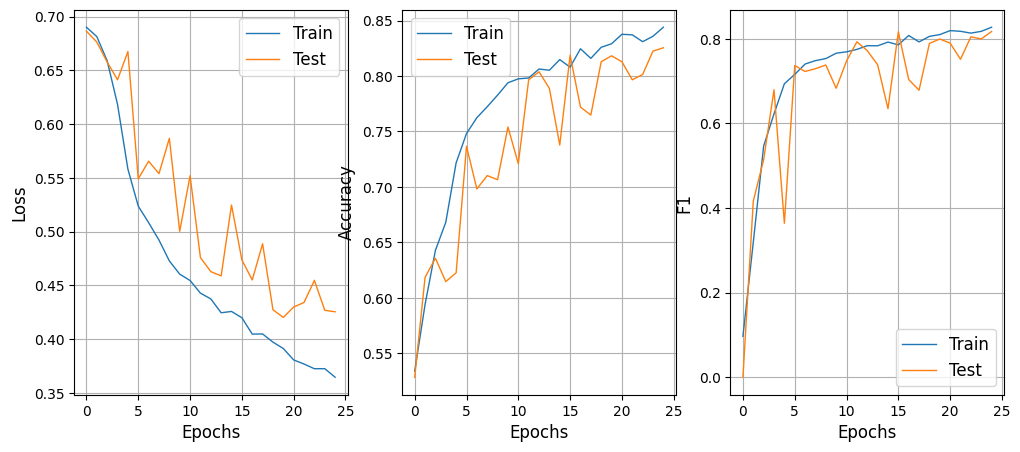

([0.6900884069285347,
  0.6813412262398062,
  0.6588524082331981,
  0.6182629338745932,
  0.5580839404782045,
  0.5236797008699584,
  0.5083496498251424,
  0.49214390527854845,
  0.4727493157085863,
  0.4604376676013169,
  0.4545417656597582,
  0.44276928033643553,
  0.4374314668109116,
  0.42453539689767705,
  0.42576219054680425,
  0.4199236862867781,
  0.4046915726175586,
  0.40481112506783123,
  0.3972144391640876,
  0.39127917558822817,
  0.38066364217151716,
  0.3768526076981165,
  0.37248502136434164,
  0.3725456926718499,
  0.3645896969489681],
 [0.6863765991651095,
  0.6762922818844135,
  0.6576058360246512,
  0.6412394688679621,
  0.6674828047935779,
  0.5491198232540717,
  0.5654687858544863,
  0.5539346704116235,
  0.5867357964699085,
  0.5002555617919335,
  0.5519919372521914,
  0.47585652883236224,
  0.46277642250061035,
  0.45883500346770656,
  0.524757621379999,
  0.47365113634329575,
  0.45504750655247617,
  0.48873703754865205,
  0.4272940181768857,
  0.42019026325299

In [434]:
model = Model(cnn, criterion, optimizer)
tr_r, ts_r, tr_ac_r, ts_ac_r tr_f1_r, ts_f1_r = model.train(train_loader, test_loader, 40)

**Вывод:**